In [1]:
import sys
sys.path.append('../..')
# from utilities.data_manager import get_historical_from_db
from utilities.bt_analysis import get_metrics, backtest_analysis
from utilities.custom_indicators import get_n_columns
from utilities.plot_analysis import plot_equity_vs_asset, plot_bar_by_month
from utilities.data_manager import ExchangeDataManager
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np
from scipy.stats import norm
import copy
import math

In [2]:
class ValueAtRisk:
    def __init__(self, df_list):
        self.df_list = df_list
        self.cov = None
        self.avg_return = None
        self.conf_level = 0.05
        self.usd_balance = 1

    def update_cov(self, current_date, occurance_data=1000):
        returns = pd.DataFrame()
        returns["temp"] = [0] * (occurance_data)
        for pair in self.df_list:
            temp_df = self.df_list[pair].copy()
            try:
                iloc_date = int(temp_df.loc[current_date]["iloc"])
                if math.isnan(iloc_date) or iloc_date-occurance_data < 0:
                    returns["long_"+pair] = -1
                    returns["short_"+pair] = -1
                else:
                    returns["long_"+pair] = temp_df.iloc[iloc_date-occurance_data:iloc_date].reset_index()["close"].pct_change()
                    returns["short_"+pair] = -temp_df.iloc[iloc_date-occurance_data:iloc_date].reset_index()["close"].pct_change()
            except Exception as e:
                returns["long_"+pair] = -1
                returns["short_"+pair] = -1
        # Generate Var-Cov matrix
        del returns["temp"]
        returns = returns.iloc[:-1]
        self.cov = returns.cov()
        self.cov = self.cov.replace(0.0, 1.0)
        # Calculate mean returns for each stock
        self.avg_return = returns.mean()
        return returns

    def get_var(self, positions):
        usd_in_position = 0
        for pair in list(positions.keys()):
            usd_in_position += positions[pair]["long"] + positions[pair]["short"]
        weights = []   
        if usd_in_position == 0:
            return 0
        for pair in list(positions.keys()):
            weights.append(positions[pair]["long"] / usd_in_position)
            weights.append(positions[pair]["short"] / usd_in_position)

        weights = np.array(weights)

        port_mean = self.avg_return.dot(weights)

        # Calculate portfolio standard deviation
        port_stdev = np.sqrt(weights.T.dot(self.cov).dot(weights))

        # Calculate mean of investment
        mean_investment = (1+port_mean) * usd_in_position

        # Calculate standard deviation of investmnet
        stdev_investment = usd_in_position * port_stdev

        # Using SciPy ppf method to generate values for the
        # inverse cumulative distribution function to a normal distribution
        # Plugging in the mean, standard deviation of our portfolio
        # as calculated above
        cutoff1 = norm.ppf(self.conf_level, mean_investment, stdev_investment)

        #Finally, we can calculate the VaR at our confidence interval
        var_1d1 = usd_in_position - cutoff1
        
        return var_1d1 / self.usd_balance * 100

In [ ]:
class BollingerTrend():
    def __init__(
        self,
        df_list,
        oldest_pair,
        parameters_obj,
        type=["long"],
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.parameters_obj = parameters_obj
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for pair in self.df_list:
            df = self.df_list[pair]
            params = self.parameters_obj[pair]
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
            
            # -- Populate indicators --
            bol_band = ta.volatility.BollingerBands(close=df["close"], window=params["bb_window"], window_dev=params["bb_std"])
            df["lower_band"] = bol_band.bollinger_lband()
            df["higher_band"] = bol_band.bollinger_hband()
            df["ma_band"] = bol_band.bollinger_mavg()

            df['long_ma'] = ta.trend.sma_indicator(close=df['close'], window=params["long_ma_window"])
            df['ema'] = ta.trend.ema_indicator(close=df['close'], window=params["ema_window"])
            df['iloc'] = range(len(df))

            df = get_n_columns(df, ["ma_band", "lower_band", "higher_band", "close"], 1)
            
            self.df_list[pair] = df
            # -- Log --
            if(show_log):
                print(self.df_list[self.oldest_pair])
                
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self, show_log=False): 
        data_open_long = []
        data_close_long = []
        data_open_short = []
        data_close_short = []

        for pair in self.df_list:
            df = self.df_list[pair]
            # -- Initiate populate --
            df["open_long_market"] = False
            df["close_long_market"] = False
            df["open_short_market"] = False
            df["close_short_market"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            if self.use_long:
                # -- Populate open long market --
                df.loc[
                    (df['n1_close'] < df['n1_higher_band']) 
                    & (df['close'] > df['higher_band']) 
                    & (df["close"] > df["long_ma"]) 
                    , "open_long_market"
                ] = True
            
                # -- Populate close long market --
                df.loc[
                    (df['close'] < df['ma_band']) 
                    # (df['close'] < df['ema']) 
                    , "close_long_market"
                ] = True

            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df['n1_close'] > df['n1_lower_band']) 
                    & (df['close'] < df['lower_band']) 
                    & (df["close"] < df["long_ma"])
                    , "open_short_market"
                ] = True
            
                # -- Populate close short market --
                df.loc[
                    (df['close'] > df['ma_band']) 
                    # (df['close'] > df['ema']) 
                    , "close_short_market"
                ] = True
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long_market']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long_market']  == True) 
                ]['pair']
            )
            data_open_short.append(
                df.loc[
                (df['open_short_market']  == True) 
                ]['pair']
            )
            data_close_short.append(
                df.loc[
                (df['close_short_market']  == True) 
                ]['pair']
            )

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        data_open_short.append(self.df_list[self.oldest_pair]['null'])
        data_close_short.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        df_open_short = pd.concat(data_open_short, axis=1)
        df_open_short['combined']= df_open_short.values.tolist()
        df_open_short['combined'] = [[i for i in j if i == i] for j in list(df_open_short['combined'])]
        df_close_short = pd.concat(data_close_short, axis=1)
        df_close_short['combined']= df_close_short.values.tolist()
        df_close_short['combined'] = [[i for i in j if i == i] for j in list(df_close_short['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        self.open_short_obj = df_open_short['combined']
        self.close_short_obj = df_close_short['combined']
        
        # -- Log --
        if(show_log):
            print("Open LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_long_market"]==True]))
            print("Close LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_long_market"]==True]))
            print("Open SHORT length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_short_market"]==True]))
            print("Close SHORT length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_short_market"]==True]))
        
        return self.df_list[self.oldest_pair]
    
    def run_backtest(self, initial_wallet=1000, leverage=1, max_var=1):
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        usd_remaining = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        positions_exposition = {}
        for pair in self.df_list:
            positions_exposition[pair] = {"long":0, "short":0}
        var = ValueAtRisk(df_list=self.df_list.copy())
        var_counter = 0
        
        for index, row in df_ini.iterrows():
            if max_var != 0:
                if var_counter == 0:
                    var.update_cov(current_date=index, occurance_data=1000)
                    var_counter = 1000
                else:
                    var_counter -= 1
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pos in current_positions:
                    actual_row = self.df_list[pos].loc[index]
                    if current_positions[pos]['side'] == "LONG":
                        close_price = actual_row['close']
                        trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_positions[pos]['size'] - fee
                    elif current_positions[pos]['side'] == "SHORT":
                        close_price = actual_row['close']
                        trade_result = (current_positions[pos]['price'] - close_price) / current_positions[pos]['price']
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_positions[pos]['size'] - fee
                if max_var != 0:
                    risk = var.get_var(positions=positions_exposition)
                else:
                    risk = 0
                # if risk == 0 and long_exposition + short_exposition > 0.1:
                #     print(positions_exposition)
                # elif math.isnan(risk):
                #     print(positions_exposition)
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close'],
                    "long_exposition":long_exposition,
                    "short_exposition":short_exposition,
                    "risk": risk
                })
            previous_day = current_day 
            
            # Sell
            close_long_row = self.close_long_obj.loc[index]
            close_short_row = self.close_short_obj.loc[index]
            if len(current_positions) > 0:
                position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "LONG"}).intersection(set(close_long_row))
                for pos in position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    long_exposition -= self.parameters_obj[pos]['wallet_exposure']
                    positions_exposition[pos]["long"] -= self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Limit",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                    })
                    del current_positions[pos]   
                short_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "SHORT"}).intersection(set(close_short_row))
                for pos in short_position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (current_positions[pos]['price'] - close_price) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    short_exposition -= self.parameters_obj[pos]['wallet_exposure']
                    positions_exposition[pos]["short"] -= self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Limit",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                    })
                    del current_positions[pos] 
                    
            # Buy
            open_long_row = self.open_long_obj.loc[index]
            if len(open_long_row) > 0:
                for pos in open_long_row:
                    # if (pos not in current_positions) and (long_exposition + self.parameters_obj[pos]['wallet_exposure'] <= 1) and (long_exposition + self.parameters_obj[pos]['wallet_exposure'] - short_exposition <= max_side_exposition):
                    if (pos not in current_positions) and (long_exposition + self.parameters_obj[pos]['wallet_exposure'] <= 1):
                        if max_var != 0:
                            new_positions = copy.deepcopy(positions_exposition)
                            new_positions[pos]["long"] += self.parameters_obj[pos]['wallet_exposure']
                            new_risk = var.get_var(positions=new_positions)
                            if new_risk > max_var:
                                continue
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['close']
                        pos_size = wallet * self.parameters_obj[pos]['wallet_exposure'] * leverage
                        long_exposition += self.parameters_obj[pos]['wallet_exposure']
                        positions_exposition[pos]["long"] += self.parameters_obj[pos]['wallet_exposure']
                        # print(positions_exposition)
                        fee = pos_size * taker_fee
                        pos_size -= fee
                        wallet -= fee
                        current_positions[pos] = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Limit",
                            "side": "LONG"
                        }
            open_short_row = self.open_short_obj.loc[index]
            if len(open_short_row) > 0:
                for pos in open_short_row:
                    if (pos not in current_positions) and (short_exposition + self.parameters_obj[pos]['wallet_exposure'] <= 1):
                        if max_var != 0:
                            new_positions = copy.deepcopy(positions_exposition)
                            new_positions[pos]["short"] += self.parameters_obj[pos]['wallet_exposure']
                            new_risk = var.get_var(positions=new_positions)
                            if new_risk > max_var:
                                continue
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['close']
                        pos_size = wallet * self.parameters_obj[pos]['wallet_exposure'] * leverage
                        short_exposition += self.parameters_obj[pos]['wallet_exposure']
                        positions_exposition[pos]["short"] += self.parameters_obj[pos]['wallet_exposure']
                        fee = pos_size * taker_fee
                        pos_size -= fee
                        wallet -= fee
                        current_positions[pos] = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Limit",
                            "side": "SHORT"
                        }
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        if len(trades) == 0:
            print("No trades")
            return None
        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }  

In [14]:
params_coin = {
    "BTC/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 100,
        "bb_std": 2.25,
        "long_ma_window": 500,
        "ema_window": 30
    },
    "ETH/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 80,
        "bb_std": 2,
        "long_ma_window": 500,
        "ema_window": 30
    },
    "NEAR/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 80,
        "bb_std": 2,
        "long_ma_window": 500,
        "ema_window": 30
    },
    "TIA/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 80,
        "bb_std": 2,
        "long_ma_window": 500,
        "ema_window": 30
    },
    "EIGEN/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 80,
        "bb_std": 2,
        "long_ma_window": 500,
        "ema_window": 30
    },
    "DOGE/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 80,
        "bb_std": 2,
        "long_ma_window": 500,
        "ema_window": 30
    },
    "TAO/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 80,
        "bb_std": 2,
        "long_ma_window": 500,
        "ema_window": 30
    },
    "TON/USDT": {
        "wallet_exposure": 1/8,
        "bb_window": 80,
        "bb_std": 2,
        "long_ma_window": 500,
        "ema_window": 30
    },
}

pair_list = list(params_coin.keys())
exchange_name = "binance"
tf = '1h'
oldest_pair = "BTC/USDT"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    df_list[pair] = df.loc[:]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2024-11-11 10:00:00,81695.34,82380.94,81668.73,81984.19,3031.716611
2024-11-11 11:00:00,81984.19,82244.67,81842.01,82134.00,1487.641110
2024-11-11 12:00:00,82133.99,82471.20,81719.21,82168.91,2599.322750


In [15]:
strat = BollingerTrend(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin,
    type=["long","short"]
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, max_var=1.5)

df_trades, df_days = backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)

Period: [2017-09-28 00:00:00] -> [2024-11-11 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 4461.64 $
Performance: 346.16 %
Sharpe Ratio: 1.04 | Sortino Ratio: 2.18 | Calmar Ratio: 1.19
Worst Drawdown T|D: -19.88% | -19.61%
Buy and hold performance: 1840.74 %
Performance vs buy and hold: -77.01 %
Total trades on the period: 2161
Average Profit: 0.65 %
Global Win rate: 39.01 %

--- Trades Information ---
Mean Trades per day: 0.83
Mean Trades Duration: 1 days 01:41:47.172605275
Best trades: +276.2 % the 2021-01-28 04:00:00 -> 2021-01-30 01:00:00 (DOGE/USDT)
Worst trades: -23.67 % the 2021-05-12 23:00:00 -> 2021-05-13 22:00:00 (DOGE/USDT)
Total Good trades on the period: 843
Total Bad trades on the period: 1318
Average Good Trades result: 5.61 %
Average Bad Trades result: -2.52 %
Mean Good Trades Duration: 1 days 18:18:08.967971530
Mean Bad Trades Duration: 0 days 15:04:30.409711684

--- Days Informations ---
Total: 2602 days recorded
Winning days: 752 days 

,open,high,low,close,volume
date,,,,,
2024-08-08 10:00:00,4.352,6.470,4.352,6.194,2268364.72
2024-08-08 11:00:00,6.194,6.288,6.119,6.169,601518.49
2024-08-08 12:00:00,6.170,6.277,6.137,6.257,587406.85
2024-08-08 13:00:00,6.257,6.332,6.210,6.248,575332.40
2024-08-08 14:00:00,6.249,6.364,6.249,6.339,568708.32
...,...,...,...,...,...
2024-11-11 10:00:00,5.311,5.354,5.300,5.321,936556.70
2024-11-11 11:00:00,5.322,5.358,5.308,5.343,665114.56
2024-11-11 12:00:00,5.343,5.355,5.248,5.289,827484.16


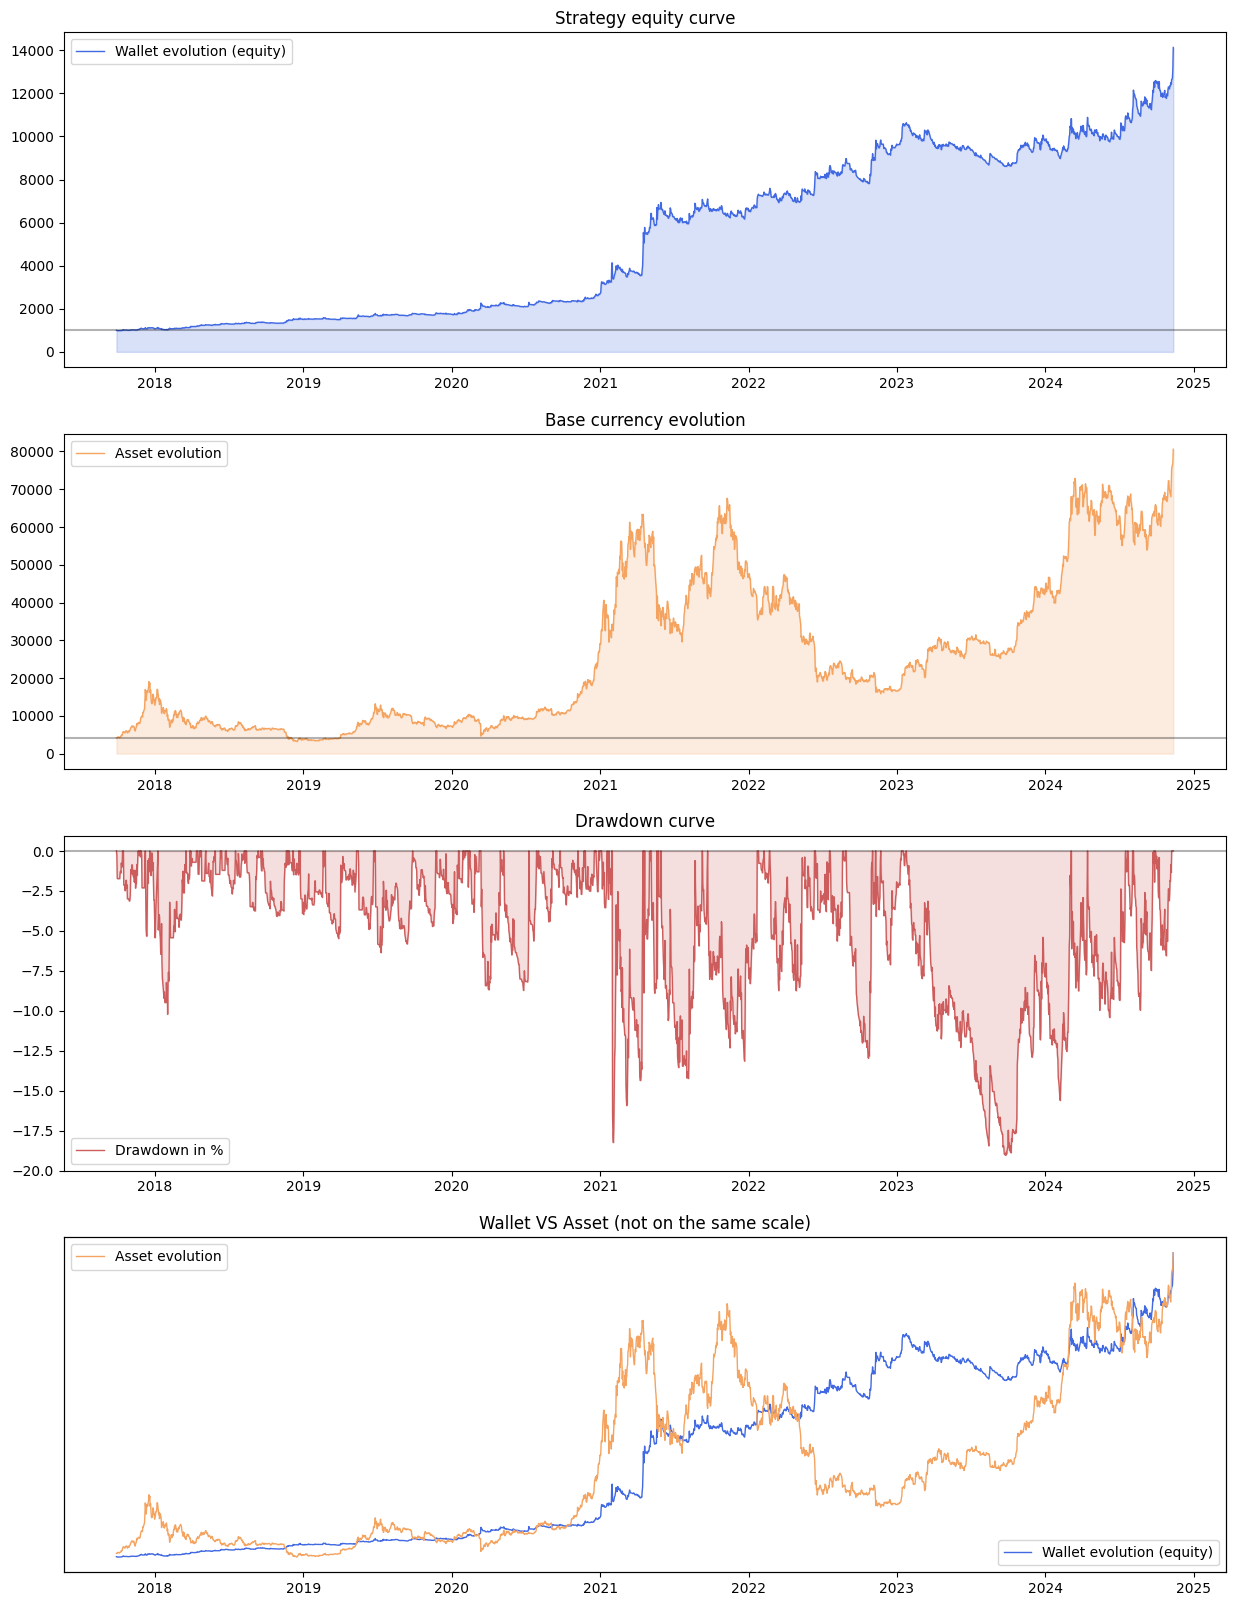

In [6]:
plot_equity_vs_asset(df_days=df_days.loc[:])

----- 2017 Cumulative Performances: 7.66% -----


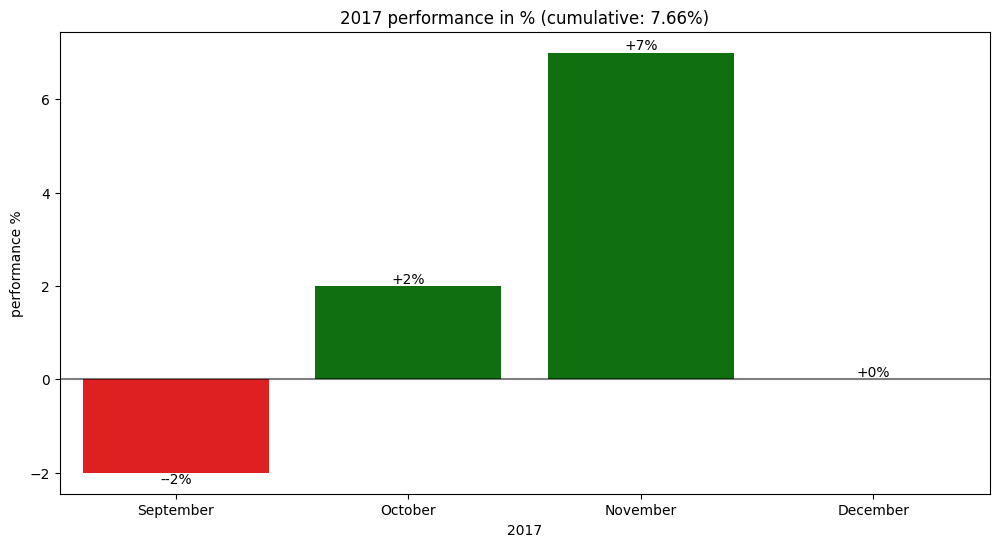

----- 2018 Cumulative Performances: 42.5% -----


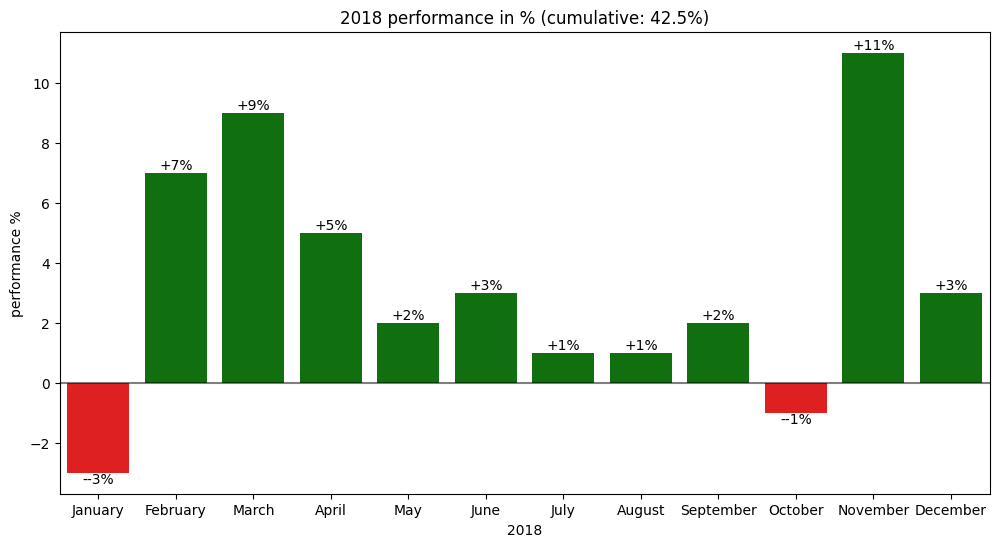

----- 2019 Cumulative Performances: 15.71% -----


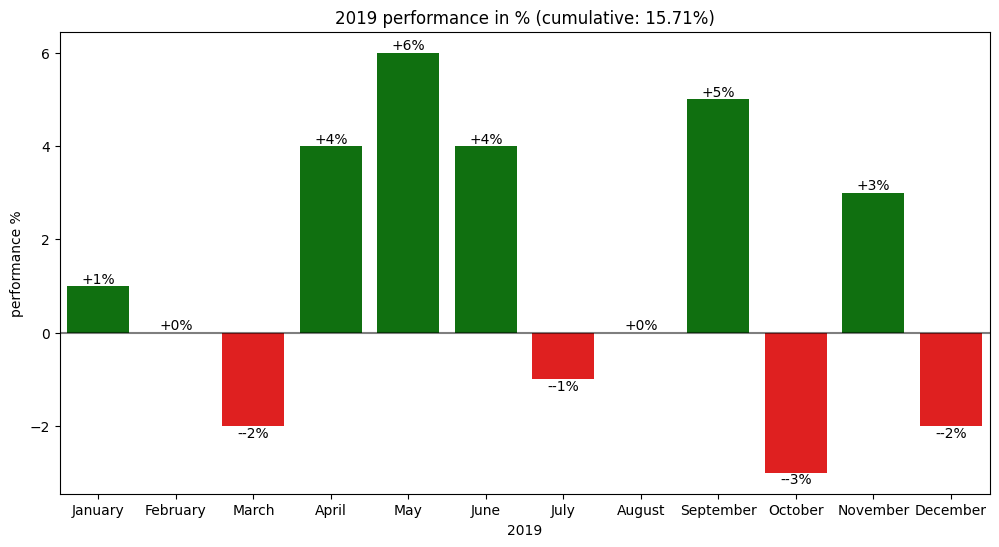

----- 2020 Cumulative Performances: 54.35% -----


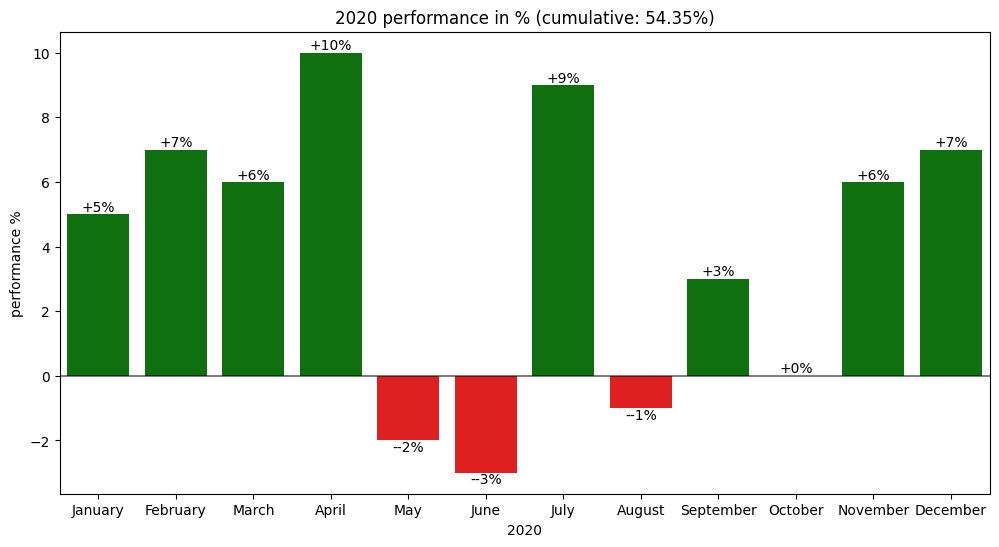

----- 2021 Cumulative Performances: 143.79% -----


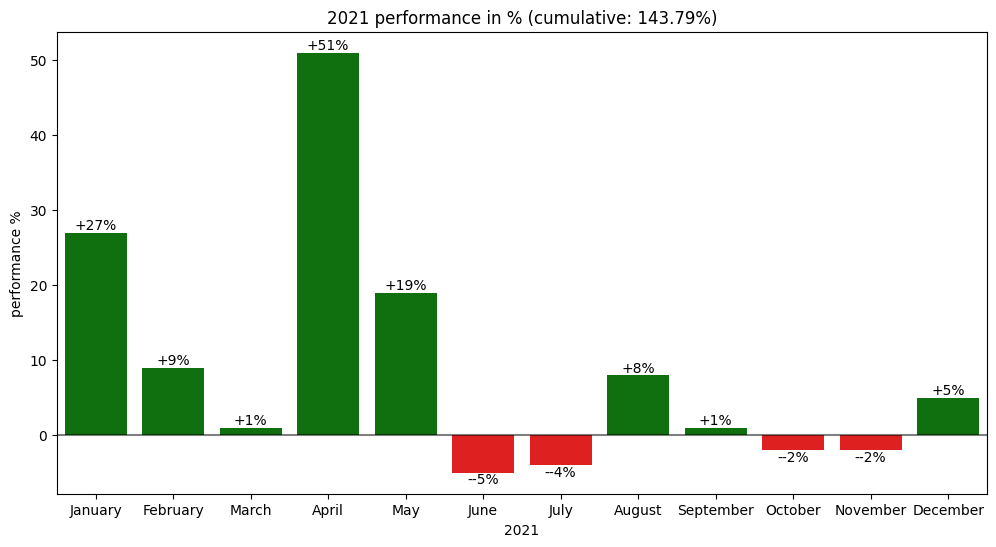

----- 2022 Cumulative Performances: 47.64% -----


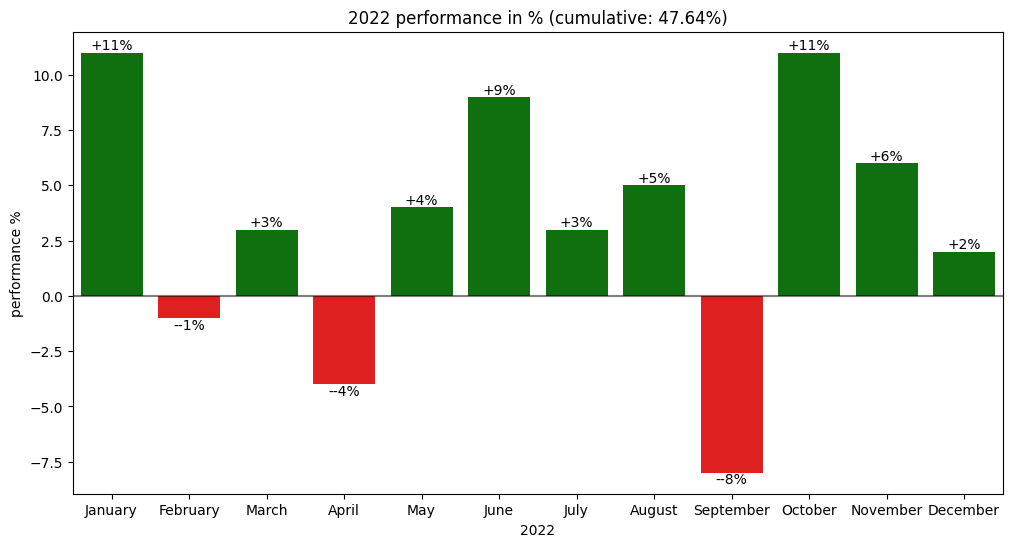

----- 2023 Cumulative Performances: 1.7% -----


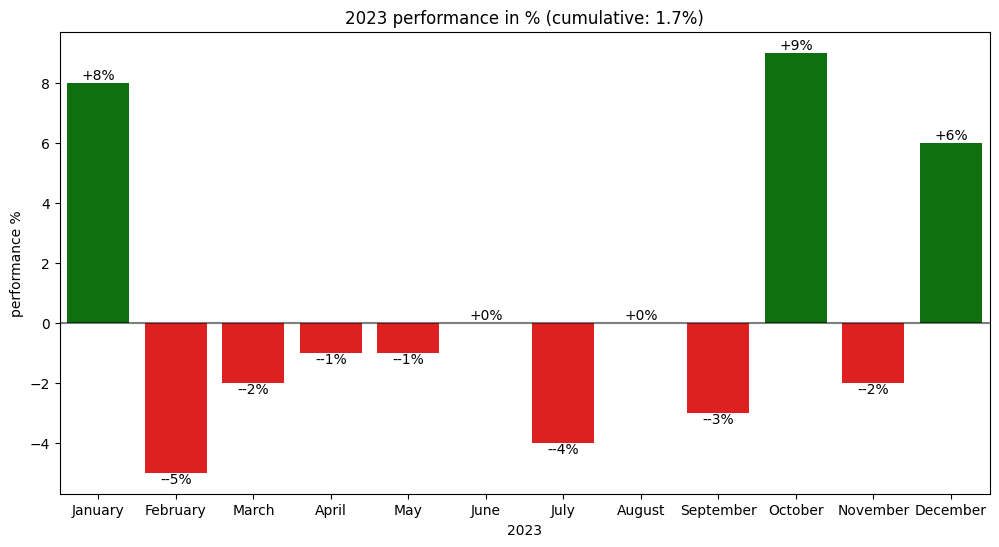

----- 2024 Cumulative Performances: 44.2% -----


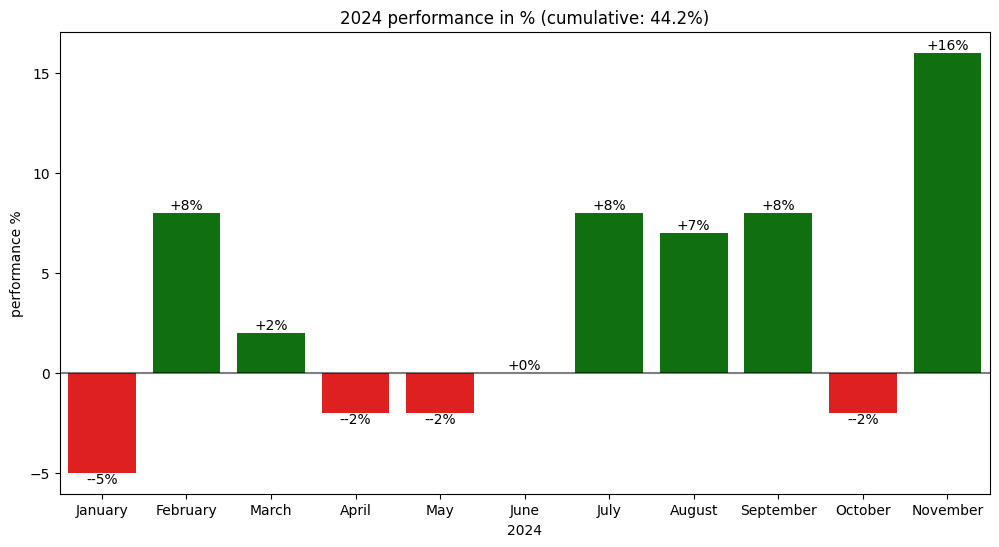

In [7]:
plot_bar_by_month(df_days=df_days)